# Making a Histogram is Easy, Right?  Right?

G Richards
(2016, 2018, 2020, 2022)
with thanks to A. Miller, Z. Ivezic, and J. Vanderplas from whom I have taken various ideas/code and cribbed this together.  With updates to my own class from [Stephen Taylor's class at Vanderbilt](https://github.com/VanderbiltAstronomy/astr_8070_s22).

## Contents
* [Nonparametric Modeling & Histograms](#one)
* [Variable-Width Bin Sizes](#two)
* [Scott's Rule](#three)
* [Kernel-based histograms](#four)

We are going to spend much of the next 2 weeks going over some basic statistics and not doing a whole lot of actual machine learning.  So today is about giving you a flavor of the kinds of things that we'll be doing later in the course.

## Nonparametric Modeling & Histograms <a class="anchor" id="one"></a>

Imagine that you have some one-dimensional ("univariate") data that you would like to try to understand.  Where by "understand" we mean "know the distribution in the measured space", i.e., you want to know the probability distribution function (PDF).  The easiest way to do that is to make a histogram.  Simple, right?

Let's work through some examples to see what problems we encounter and how we might overcome them.

In [1]:
# Execute this cell
# This is just to get some things setup for later
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
# Execute this cell to generate a univariate data array, x
# this is the same data used in Ivezic, Figure 6.5

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 1000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

Now let's take a first look at the data.  Use 
```python
plt.hist()
```
where that function plots a histogram of any univariate data array given as an argument.  It takes lots of other arguments too.  See (https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html).  You might start with `histtype = "step"` so that we can later add information to the plot and still see the original histogram.  See what happens if you don't do this.

(array([  4.,   9.,  27., 191., 429., 225.,  76.,  14.,   3.,   3.]),
 array([-6.92142972, -3.53746832, -0.15350693,  3.23045447,  6.61441586,
         9.99837726, 13.38233865, 16.76630005, 20.15026145, 23.53422284,
        26.91818424]),
 [<matplotlib.patches.Polygon at 0x7f80a0bc3640>])

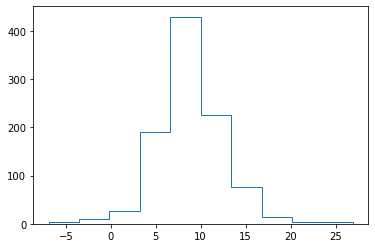

In [7]:
plt.hist(x,histtype='step') #Complete

How would you characterize this distribution?  Could we reasonably think of it as a normal (Gaussian) distribution that we could characterize by some mean and standard deviation?  Maybe, but even just by looking at this plot we see that it wouldn't be a particularly good description of the data.

Now do what we would typically do in astronomy: try re-plotting the histogram a couple of different ways to see if it reveals anything more about the data.  Try using only 5 bins `bins=5`, 20 bins `bins=20`, and with left-centered bins `align = "left"` instead of 10 `"mid"` centered bins (which is the default) 

(array([  4.,   9.,  27., 191., 429., 225.,  76.,  14.,   3.,   3.]),
 array([-6.92142972, -3.53746832, -0.15350693,  3.23045447,  6.61441586,
         9.99837726, 13.38233865, 16.76630005, 20.15026145, 23.53422284,
        26.91818424]),
 [<matplotlib.patches.Polygon at 0x7f80a0b2b7f0>])

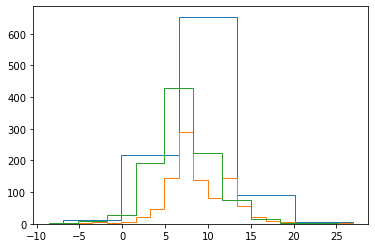

In [8]:
plt.hist(x,bins=5,histtype='step') #Complete
plt.hist(x,bins=20,histtype='step') #Complete
plt.hist(x,align='left',histtype='step') #Complete

Note that the heights of these PDFs are all different!  That's because the y-axis is scaled to the first histogram.  Try using `density = True` so that the histograms are all normalized to 1.  

(array([0.00120494, 0.00271112, 0.00813335, 0.05753591, 0.12922986,
        0.0677779 , 0.02289387, 0.00421729, 0.00090371, 0.00090371]),
 array([-6.92142972, -3.53746832, -0.15350693,  3.23045447,  6.61441586,
         9.99837726, 13.38233865, 16.76630005, 20.15026145, 23.53422284,
        26.91818424]),
 [<matplotlib.patches.Polygon at 0x7f80a0b12e80>])

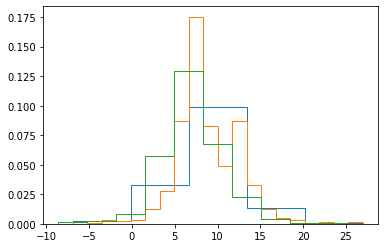

In [9]:
plt.hist(x,bins=5,histtype='step',density = True) #Complete
plt.hist(x,bins=20,histtype='step',density=True) #Complete
plt.hist(x,align='left',histtype='step',density=True) #Complete

We find that small changes in parameters to the histogram function *significantly* change the PDF.  That's bad, because the underlying data clearly have **not** changed.

## Variable Width Bin Sizes <a class="anchor" id="two"></a>

One of the problems with histograms is that some bins end up with little (or no) data.  We can fix this by making **variable-width bin sizes** that have the ***same number of objects in each bin***.  How can we do this?

In [10]:
#Execute this cell
a = np.linspace(1,42,num=42)
print(a)
print(a[::2])
print(a[::3])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42.]
[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41.]
[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40.]


If you are familiar with slicing, then you know that `[::2]` and `[::3]` say to count by 2 and count by 3.  But that isn't what they really do.  They say to take every other index of the array or every 3rd index of the array.  So, if your array is sorted (like `a` is), then you could use this to instead define the number of values in a bin.  That is for any given value of `M`

    bins = np.append(np.sort(x)[::M], np.max(x))
    
would give bins with `M` objects in each bin.  

So if `M=3` and 

    x = [1,3,5,7,9,11,13,21,29,35]
    
then 
    
    bins = [1 7 13 35]

Note that you need to add the maximum value to set the right edge of the last bin.  

Try it for `M=100` and `M=30` (100 and 30 objects in a bin).

In [11]:
bins100 = np.append(np.sort(x)[::100], np.max(x)) #Complete
bins30 = np.append(np.sort(x)[::30],np.max(x)) #Complete
print(len(bins100),len(bins30))

11 34


Now let's replot our histogram using both of those binning choices.

(-5.0, 25.0)

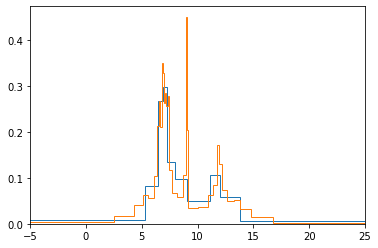

In [12]:
#Note that the underscores here are suppressing the array output
#so that we just see the plots
_ = plt.hist(x, bins=bins100, density=True, histtype="step") #Complete
_ = plt.hist(x,bins=bins30,density=True,histtype='step') #Complete
plt.xlim(-5,25)

Again, this can look pretty different depending on what the number of objects you choose as the minimum for each bin and compared to the plots above.  And it looks a lot different from the plots above.

So, what is the "right" way to set the bin size?

There is no "right" way, but we'll encounter some suggestions in Chapter 4.  Let's take a quick look at them now.

## Scott's Rule <a class="anchor" id="three"></a>

**Scott's rule** suggests that the optimal bin width is 
$$\Delta_b = \frac{3.5\sigma}{N^{1/3}}.$$

That's great, but what if we don't know the standard deviation, $\sigma$ (e.g., if the distribution isn't really Gaussian)?  We can then instead used the **Freedman-Diaconis rule**: 
$$\Delta_b = \frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7\sigma_G}{N^{1/3}}.$$  
Let's try that, where $\sigma_G$ is 0.7413 times the difference between the upper and lower quartiles, which you can determine with [np.percentile()](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html).

In [13]:
q25 = np.percentile(x,25) #Complete
q75 = np.percentile(x,75) #Complete
#Or better yet
q25,q75 = np.percentile(x,[25,75]) #Complete
sigmaG = 0.7413*(q75-q25) #Complete
print(sigmaG)

3.673192301978193


Compare this to what you get using `stats.sigmaG()` from the astroML package.  You'll have to import stats from astroML and give it a different name since `stats` right now refers to `scipy.stats`.

In [14]:
from astroML import stats as astroMLstats
sigmaG2 = astroMLstats.sigmaG(x)
print(sigmaG2)

3.6731977984018402


Now set the bin size accordingly, using [np.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and plot.  Make sure that you don't throw away the last object in data set!  How many bins do you get?  How does that compare to what we were using above?

In [18]:
binsize = 2.7*sigmaG/(N**(1./3)) #Complete
print(binsize)
binsG = np.append(np.arange(start=x.min(), stop=x.max(), step=binsize), x.max()) #Complete
print(len(binsG))
print(binsG)

0.9917619215341122
36
[-6.92142972e+00 -5.92966780e+00 -4.93790588e+00 -3.94614396e+00
 -2.95438203e+00 -1.96262011e+00 -9.70858190e-01  2.09037311e-02
  1.01266565e+00  2.00442757e+00  2.99618950e+00  3.98795142e+00
  4.97971334e+00  5.97147526e+00  6.96323718e+00  7.95499910e+00
  8.94676102e+00  9.93852295e+00  1.09302849e+01  1.19220468e+01
  1.29138087e+01  1.39055706e+01  1.48973326e+01  1.58890945e+01
  1.68808564e+01  1.78726183e+01  1.88643802e+01  1.98561422e+01
  2.08479041e+01  2.18396660e+01  2.28314279e+01  2.38231898e+01
  2.48149518e+01  2.58067137e+01  2.67984756e+01  2.69181842e+01]


(-5.0, 25.0)

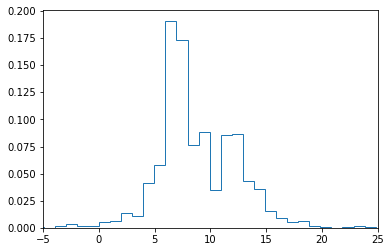

In [19]:
 _= plt.hist(x,bins=binsG,histtype='step',density=True) #Complete   
plt.xlim(-5,25)

Did you find that tedious?  Me too.  Fortunately there is a shortcut!  Try it.

(-5.0, 25.0)

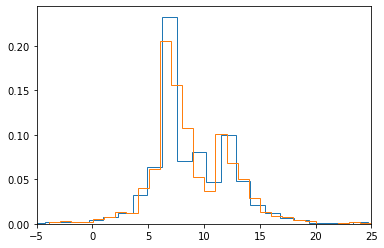

In [20]:
from astropy.visualization.hist import hist as fancyhist
_ = fancyhist(x, bins="scott", histtype="step",density=True)
_ = fancyhist(x, bins="freedman", histtype="step",density=True)
plt.xlim(-5,25)

Note that even those don't yield quite the same results!  But we can do better!

## Kernel-based Histograms <a class="anchor" id="four"></a>

An obvious thing to do is to simply show all of the data.

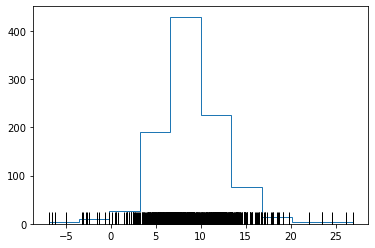

In [21]:
# execute this cell
plt.hist(x,histtype="step")
plt.plot(x, 0*x, '|', color='k', markersize=25) #Note markersize is (annoyingly) in *points*

This is called a **rug plot** and now we have a better idea of where most of the data are and where the gaps really are (as opposed to where the binning makes them *appear* to be).  However, the markers are all piled up, so we have lost all sense of the relative numbers of objects.  Are there ~10 at x=5 or could there be 100?

This is where [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) comes in.  (As a side note, KDE is the core of the quasar classification work that I do, which is how I got into this machine learning business in the first place.  Way before it was popular I might add!)  In short the idea here is to represent each data point not as a delta function, but rather as a distribution (e.g., a Gaussian).  Then those individual distributions ("kernels") are summed up to produce the PDF.  One of the advantages of this approach is that it combines the best of 1) the histogram and 2) the rug plot: where 1) tells us the relative height of the distribution and 2) centers the data points at the actual location of the data instead of within some arbitrary bin.

Just about any distribution can be used as the kernel, but the most common are a **Gaussian kernel** and an **Epanechnikov kernel**.  One downside of the Gaussian kernel is that the tails are technically infinite in extent.  So each point has some finite probability of being *everywhere*.  The Epanechnikov kernel has truncated wings.  

One still has the problem of deciding the width of the kernel (e.g., for the Gaussian the "mean" is fixed at the value of the point, but how wide should you make the Gaussian?).  For my work, we do this with a self-test of the data.  Specifically, what is the optimal width such that objects with a known classification are indeed given that classification by our machine learning algorithm.  But that is the topic for another day.  For now, we'll just play with the widths by hand to see what might work best.  N.B. the widths of the kernel distribution are referred to as **bandwidth**.

In [22]:
# execute this cell to load the KDE module
# No need to try to understand what is going on here now, we'll come back to this later.
# But see the note below about "xgrid"
from sklearn.neighbors import KernelDensity
xgrid = np.linspace(x.min(),x.max(),1000)  # Use this instead of 'x' for plotting
def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

Before we try the Gaussian and Epanechnikov kernels, let's first start with a tophat using `kernel = "tophat"`, which will produce a plot much like the rug plot.

Start with `bandwidth=0.01`.  See what happens when you adjust this.

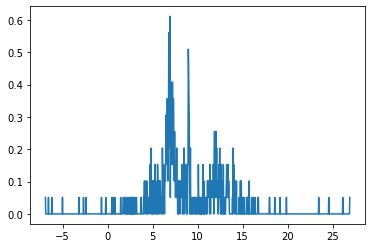

In [23]:
PDFtophat = kde_sklearn(x,bandwidth=0.01,kernel="tophat") #Complete
plt.plot(xgrid,PDFtophat) #Complete

The defaults give a result that is essentially what you would get if you made a histogram with a really large number of bins.

Now let's compare what happens when we adjust the bandwidth (which is just the width of the kernel function).  Try 
`bandwidth=0.1` and `bandwidth=0.5`.

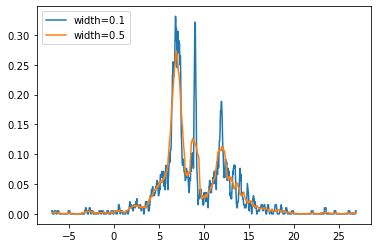

In [24]:
PDFtophat1 = kde_sklearn(x,bandwidth=0.1,kernel='tophat') #Complete
plt.plot(xgrid,PDFtophat1,label='width=0.1') #Complete

PDFtophat5 = kde_sklearn(x,bandwidth=0.5,kernel='tophat') #Complete
plt.plot(xgrid,PDFtophat5,label='width=0.5') #Complete
    
plt.legend(loc="upper left")

Now let's see what we get with the Gaussian `kernel="gaussian"` and Epanechnikov `kernel="epanechnikov"` kernels.  Play with the bandwidths until you get something that looks reasonable (and roughly matches) for the two kernels.  They need not be the same.

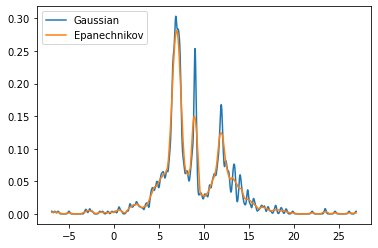

In [27]:
PDFgaussian = kde_sklearn(x,bandwidth=0.1,kernel="gaussian") #Complete 
PDFepanechnikov = kde_sklearn(x,bandwidth=0.5,kernel="epanechnikov") #Complete
plt.plot(xgrid,PDFgaussian,label="Gaussian") #Complete
plt.plot(xgrid,PDFepanechnikov,label="Epanechnikov") #Complete
plt.legend(loc='upper left') #Complete

This is pretty different from the histogram that we started out with, isn't it?

Lastly, we have used 2000 points, so you aren't seeing the kernel shape for the individual points.  Try remaking $x$ with only `N=15` points and see what this looks like.  Adjust the figure size (using `figsize`), the bandwidth and the axis limits until you can see the differences between the two kernels.  Play with the bandwidths to see what affect they have now that you can see the individual kernels.

In [28]:
#Redefine "x" using the code from the cell above near the start of the notebook using N=15
#You might want to rename `x` and `N` so that they don't conflict
#with the names above (if you don't run the cells in order).

np.random.seed(0)
N = 15
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]



(2.0, 17.0)

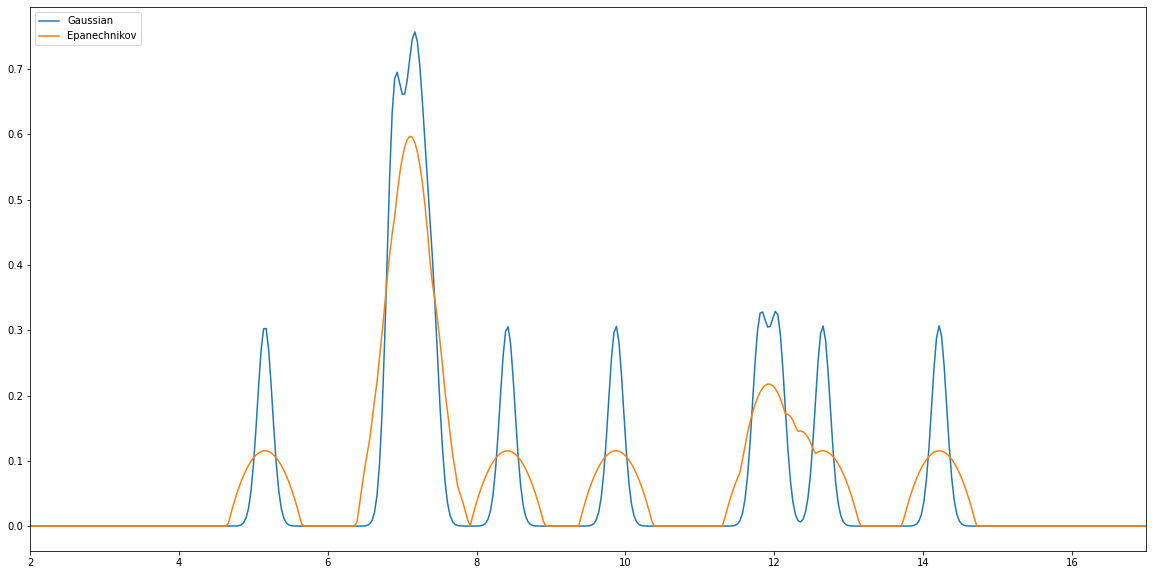

In [37]:
#Make a plot that illustrates the shape of the kernel
plt.figure(figsize=(20,10)) #Complete
PDFgaussian = kde_sklearn(x,bandwidth=0.1,kernel='gaussian') #Complete
PDFepanechnikov = kde_sklearn(x,bandwidth=0.5,kernel='epanechnikov') #Complete
plt.plot(xgrid,PDFgaussian,label="Gaussian") #Complete
plt.plot(xgrid,PDFepanechnikov,label="Epanechnikov") #Complete
plt.legend(loc='upper left') #Complete
plt.xlim((2,17)) #Complete

### HISTOGRAMS TAKE-AWAY MESSAGE:

Making a histogram is the first-cut we make of data, and it's certainly one of the most sensible things to try to get a feel for the data. But we can't just do it without thinking. We need to explore bin sizes and KDE smoothing bandwidths to tease out the structure in the distributions, and overcome any finite sample effects in bins by potentially having variable bin widths.